<a href="https://colab.research.google.com/github/kar10tik/Elementary-Arduino/blob/main/PEMFC_Prognostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install tensorflow==2.9.0
import optuna
!pip install statsmodels
!pip install plotly

In [ ]:
# Check Available GPUs
!nvidia-smi
!cat /proc/meminfo

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
import statsmodels.api as sm #For Locally Weighted Scatterplot Smoothening (LOWESS) 
import tensorflow as tf
#%tensorflow_version 2.9
from tensorflow import keras, data
from random import random
import typing
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
#--NotebookApp.iopub_data_rate_limit = 1.0e10
#print(tf.__version__)

In [2]:
# Set Random Seeds to Get Reproducible Results
seed_value = 0
# Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.data_table import DataTable
DataTable.max_columns = 30

In [ ]:
def drop_high_corr_columns(df):
  #cor_matrix = df.corr().abs()
  #upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
  #to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
  to_drop = ['U1 (V)', 'U2 (V)', 'U3 (V)', 'U4 (V)', 'U5 (V)', 'I (A)']
  return df.drop(columns = to_drop, axis = 1)

In [4]:
# IEEE PHM 2014 Data Challenge Dataset without ripples
df_part1 = pd.read_csv(r'/content/drive/MyDrive/Research/Datasets/PEMFC/IEEE2014DataChallengeData/FC1_Without_Ripples/FC1_Ageing_part1.csv', encoding = "ISO-8859-1")
df_part2 = pd.read_csv(r'/content/drive/MyDrive/Research/Datasets/PEMFC/IEEE2014DataChallengeData/FC1_Without_Ripples/FC1_Ageing_part2.csv', encoding = "ISO-8859-1")
df_part3 = pd.read_csv(r'/content/drive/MyDrive/Research/Datasets/PEMFC/IEEE2014DataChallengeData/FC1_Without_Ripples/FC1_Ageing_part3.csv', encoding = "ISO-8859-1")
frames = [df_part1, df_part2, df_part3]
phm_dataset_1 = pd.concat(frames, ignore_index = True).astype('float32')
#phm_dataset_1_d = drop_high_corr_columns(phm_dataset_1)
# Elucidate statistical features
#phm_dataset_1.describe().transpose()
#phm_dataset_1.cov()
#plt.plot(list(phm_dataset['Time (h)']), list(phm_dataset['Utot (V)']))

In [ ]:
cov1 = phm_dataset_1.corr()
cov1[cov1.iloc[:,:]>= 0.95].dropna(how='all') 

In [5]:
# IEEE PHM 2014 Data Challenge Dataset with ripples
df_part1 = pd.read_csv(r'/content/drive/MyDrive/Research/Datasets/PEMFC/IEEE2014DataChallengeData/Full_FC2_With_Ripples/FC2_Ageing_part1.csv', encoding = "ISO-8859-1")
df_part2 = pd.read_csv(r'/content/drive/MyDrive/Research/Datasets/PEMFC/IEEE2014DataChallengeData/Full_FC2_With_Ripples/FC2_Ageing_part2.csv', encoding = "ISO-8859-1")
phm_dataset_2 = pd.concat([df_part1, df_part2], ignore_index = True).dropna(axis=1, how='all').astype('float32')
#phm_dataset_2_d = drop_high_corr_columns(phm_dataset_2)
#plt.plot(list(phm_dataset_2['Time (h)']), list(phm_dataset_2['Utot (V)']))
# Elucidate statistical features
#phm_dataset_2.describe().transpose()
#phm_dataset_2.cov()

In [ ]:
cov2 = phm_dataset_2.corr()
cov2[cov2.iloc[:,:]>= 0.95].dropna(how='all') 

In [6]:
# Multivariate Time Series
# convert series to supervised learning
# Standard practice in time series forecasting to use lagged observations (e.g. t-1) as input variables to forecast the current time step (t)
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis = 1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace = True)
	return agg

In [ ]:
def evaluate_metrics(y_true, y_pred):
  """
  Return RMSE and MAE
  """
  rmse = math.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  return rmse, mae, r2

# Model Building and training Functions

In [10]:
BATCH_SIZE = 72
class Neural_Networks():

    def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, volt_scaler) -> None:
        """
        volt_scaler is the MinMaxScaler object used to normalize Utot(V) in range (0,1) 
        """
        self.mae = keras.losses.MeanAbsoluteError()
        self.x_train, self.y_train = x_train, y_train  # Training set
        self.x_valid, self.y_valid = x_valid, y_valid # Validation set
        self.x_test, self.y_test = x_test, y_test   # Test set
        self.volt_scaler = volt_scaler
        # Hyperparameter tuning results for static loading dataset with 50% data as training set 
        # stored as attributes for easy accessibility
        self.opt_LSTM_units, self.opt_GRU_units = 75, 92
        self.opt_LSTM_LR, self.opt_GRU_LR = 0.00045967464871265887, 0.0006899549137745159 #Adam
        self.opt_LSTM_dropout, self.opt_GRU_dropout = 0.10204101575985941, 0.06017063859125542
        self.opt_CNN_LSTM_units, self.opt_CNN_GRU_units = 108, 102
        self.opt_CNN_LSTM_filters, self.opt_CNN_GRU_filters = 93, 97
        self.opt_CNN_LSTM_LR, self.opt_CNN_GRU_LR = 0.00039458365054797465, 0.0005623902764462512 #Adam
        self.opt_CNN_LSTM_dropout, self.opt_CNN_GRU_dropout = 0.21587038777591175, 0.06863870820110385
        self.opt_CNN_BidirLSTM_units, self.opt_CNN_BidirGRU_units = 100, 71
        self.opt_CNN_BidirLSTM_filters, self.opt_CNN_BidirGRU_filters = 79, 95
        self.opt_CNN_BidirLSTM_LR, self.opt_CNN_BidirGRU_LR = 0.0001415542408060021, 0.00011281449394542564 #Adam
        self.opt_CNN_BidirLSTM_dropout, self.opt_CNN_BidirGRU_dropout = 0.311649235809069, 0.22507334379858374


    def build_LSTM_model(self, hidden_neurons, activator, drop_out, optimizer):
        """
        LSTM Network
        Prediction timeframe length: 604 h
        Units of a Dense layer is the shape of the Dense layer output
        Input_shape is the shape of the Dense layer input
        """
        keras.backend.clear_session()
        output_neurons = 1
        LSTM_layer = keras.layers.LSTM(hidden_neurons, input_shape = (self.x_train.shape[1], self.x_train.shape[2]), 
                dropout = drop_out, activation = activator)
        # For bidirectional layer, move input_shape argument from LSTM layer to Bidirectional
        bidir_LSTM_layer = keras.layers.Bidirectional(LSTM_layer)
        # Dropout added as validation loss increasing => DNN Overfitting
        output_layer = keras.layers.Dense(output_neurons)
        test_model = keras.Sequential(layers = (LSTM_layer, output_layer))
        test_model.reset_states()
        test_model.compile(optimizer = optimizer, loss = self.mae)
        test_model.summary()
        return test_model


    def build_CNN_LSTM_model(self, hidden_neurons, activator_CNN, drop_out, filters = 64, OPTIMIZER = 'adam', activator_LSTM = 'tanh'):
        """
        LSTM-CNN Network
        Prediction timeframe length: 604 h
        filters default 64
        """
        keras.backend.clear_session()
        output_neurons = 1
        LSTM1 = keras.layers.LSTM(hidden_neurons, dropout = drop_out, activation = activator_LSTM)
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator_CNN, 
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_model = keras.Sequential(layers = (conv1D, LSTM1, keras.layers.Dense(output_neurons)))
        cnn_model.reset_states()
        cnn_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_model


    def build_CNN_BidirLSTM_model(self, hidden_neurons, activator_CNN, drop_out, filters = 64, OPTIMIZER = 'adam', activator_LSTM = 'tanh'):
        """
        Bidirectional LSTM-CNN Network
        Prediction timeframe length: 604 h
        filters default 64
        """
        keras.backend.clear_session()
        output_neurons = 1
        LSTM1 = keras.layers.LSTM(hidden_neurons, dropout = drop_out, activation = activator_LSTM)
        bidir_LSTM1 = keras.layers.Bidirectional(LSTM1, input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator_CNN, 
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_model = keras.Sequential(layers = (conv1D, bidir_LSTM1, keras.layers.Dense(output_neurons)))
        cnn_model.reset_states()
        cnn_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_model


    def build_CNN_GRU_model(self, hidden_neurons, activator, drop_out, filters = 64, OPTIMIZER = 'adam'):
        """
        1D-CNN-GRU Network
        """
        keras.backend.clear_session()
        output_neurons = 1
        GRU_layer = keras.layers.GRU(hidden_neurons, dropout = drop_out)
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator, 
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_model = keras.Sequential(layers = (conv1D, GRU_layer, keras.layers.Dense(output_neurons)))
        cnn_model.reset_states()
        cnn_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_model


    def build_CNN_BidirGRU_model(self, hidden_neurons, activator, drop_out, filters = 64, OPTIMIZER = 'adam'):
        """
        1D-CNN-Bidirectional GRU Network
        """
        keras.backend.clear_session()
        output_neurons = 1
        GRU_layer = keras.layers.GRU(hidden_neurons, dropout = drop_out)
        bidir_GRU = keras.layers.Bidirectional(GRU_layer, input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        conv1D = keras.layers.Conv1D(filters = filters, kernel_size = 3, strides = 1, activation = activator, 
                padding = 'causal', input_shape = (self.x_train.shape[1], self.x_train.shape[2]))
        cnn_model = keras.Sequential(layers = (conv1D, bidir_GRU, keras.layers.Dense(output_neurons)))
        cnn_model.reset_states()
        cnn_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return cnn_model
 

    def build_GRU_model(self, hidden_neurons, activator, drop_out, OPTIMIZER = 'adam'):
        """
        GRU Network
        """
        keras.backend.clear_session()
        output_neurons = 1
        GRU_layer = keras.layers.GRU(hidden_neurons, dropout = drop_out, activation = activator)
        gru_model = keras.Sequential(layers = (GRU_layer, keras.layers.Dense(output_neurons)))
        gru_model.reset_states()
        gru_model.compile(optimizer = OPTIMIZER, loss = self.mae)
        return gru_model

    
    def train_model(self, model, epoch_size = 150, BATCH_SIZE = BATCH_SIZE):
        """
        Train the model with specified epochs and batch size
        """
        early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'min')
        history = model.fit(self.x_train, self.y_train, epochs = epoch_size, batch_size = BATCH_SIZE, callbacks = [early_stop],
                validation_data=  (self.x_valid, self.y_valid), shuffle = False)
        return history


    def predict(self, model):
        """
        model: DNN model built
        volt_scaler: Scaler used to fit output/independent variable data during initial data processing
        """
        # Predict
        yhat = model.predict(self.x_test)
        x_test = self.x_test.reshape((self.x_test.shape[0], self.x_test.shape[2]))
        inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis=1)
        inv_yhat = self.volt_scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        y_test = self.y_test.reshape((len(self.y_test), 1))
        inv_y = np.concatenate((y_test, x_test[:, 1:]), axis=1)
        inv_y = self.volt_scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        return inv_y, inv_yhat


    def plot_loss_curves(self, history, epoch_size):
        """
        Visualize Model Results
        """
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']
        epochs = range(1, epoch_size + 1)
        plt.figure()
        plt.plot(epochs, training_loss, label = 'Training Loss')
        plt.plot(epochs, validation_loss, label = 'Validation Loss')
        plt.legend()
        plt.show()


    def evaluate_metrics(self, y_true, y_pred):
        """
        Return RMSE, MAE, R2
        """
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return rmse, mae, r2   


    def evaluate_loss_function(self, y_true, y_pred):
        """
        RMSE is chosen as the loss function for hyperparameter optimization while MAE is chosen for NN training
        """
        return math.sqrt(mean_squared_error(y_true, y_pred))


    def loop_model(self, n_loops = 50, df_type = 2):
        """
        Loop - Min, Max, Average of RMSE, MAE, R2, predicted RUL, and relative error of predicted RUL over number of trials, default 50
        df_type = 1 is for static loading dataset
        df_type = 2 is for dynamic loading dataset
        """
        arr_RMSE, arr_MAE, arr_R2, arr_RUL, arr_RUL_RE = list(), list(), list(), list(), list()
        for _ in range(n_loops):
          print("Trial ", _+1 ," of", n_loops)
          # model = self.build_LSTM_model(self.opt_LSTM_units, 'tanh', self.opt_LSTM_dropout, tf.keras.optimizers.Adam(learning_rate = self.opt_LSTM_LR))
          model = self.build_GRU_model(self.opt_GRU_units, 'tanh', self.opt_GRU_dropout, tf.keras.optimizers.Adam(learning_rate = self.opt_GRU_LR))
          # model = self.build_CNN_LSTM_model(self.opt_CNN_LSTM_units, 'tanh', self.opt_CNN_LSTM_dropout, self.opt_CNN_LSTM_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_LSTM_LR))
          # model = self.build_CNN_GRU_model(self.opt_CNN_GRU_units, 'tanh', self.opt_CNN_GRU_dropout, self.opt_CNN_GRU_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_GRU_LR))
          # model = self.build_CNN_BidirLSTM_model(self.opt_CNN_BidirLSTM_units, 'tanh', self.opt_CNN_BidirLSTM_dropout, self.opt_CNN_BidirLSTM_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_BidirLSTM_LR))
          # model = self.build_CNN_BidirGRU_model(self.opt_CNN_BidirGRU_units, 'tanh', self.opt_CNN_BidirGRU_dropout, self.opt_CNN_BidirGRU_filters, tf.keras.optimizers.Adam(learning_rate = self.opt_CNN_BidirGRU_LR))
          history = self.train_model(model, epoch_size = 150, BATCH_SIZE = BATCH_SIZE)
          y_true, y_pred = self.predict(model)
          rmse, mae, r2 = self.evaluate_metrics(y_true, y_pred)
          # initial voltage for threshold chosen as first voltage in training set of each dataset
          threshold_4perc = 3.1971 if df_type == 2 else 3.2028
          validation_h = len(self.y_valid) #102 if df_type == 2 else 115
          true_failure_h = [i for i,v in enumerate(y_true) if v < threshold_4perc][0]
          true_RUL = validation_h + true_failure_h
          try:
            pred_failure_h = [i for i,v in enumerate(y_pred) if v < threshold_4perc][0]
          except IndexError:  
            pred_failure_h = len(y_pred)  
          pred_RUL = validation_h + pred_failure_h
          arr_RUL.append(pred_RUL) # RUL = validation set time + time to failure
          arr_RUL_RE.append(abs(pred_RUL - true_RUL)/true_RUL)
          print(f"RMSE: {rmse}, MAE: {mae}")
          arr_RMSE.append(rmse)
          arr_MAE.append(mae)
          arr_R2.append(r2)
          del model
          keras.backend.clear_session()

        arr_RMSE, arr_MAE, arr_R2, arr_RUL, arr_RUL_RE = np.array(arr_RMSE), np.array(arr_MAE), np.array(arr_R2), np.array(arr_RUL), np.array(arr_RUL_RE)
        min_RMSE, min_MAE, min_R2, min_RUL, min_RUL_RE = arr_RMSE.min(), arr_MAE.min(), arr_R2.min(), arr_RUL.min(), arr_RUL_RE.min()
        max_RMSE, max_MAE, max_R2, max_RUL, max_RUL_RE = arr_RMSE.max(), arr_MAE.max(), arr_R2.max(), arr_RUL.max(), arr_RUL_RE.max()
        avg_RMSE, avg_MAE, avg_R2, avg_RUL, avg_RUL_RE = arr_RMSE.mean(), arr_MAE.mean(), arr_R2.mean(), arr_RUL.mean(), arr_RUL_RE.mean()
        print("RMSE Array", arr_RMSE, end = '\n')
        print("MAE Array", arr_MAE, end = '\n')
        print("R2 Array", arr_R2, end = '\n')
        print("RUL Array", arr_RUL, end = '\n')
        print("RUL_RE Array", arr_RUL_RE, end = '\n')
        print(f"Mean RMSE: {avg_RMSE}, Min RMSE: {min_RMSE}, Max RMSE: {max_RMSE}")
        print(f"Mean MAE: {avg_MAE}, Min MAE: {min_MAE}, Max MAE: {max_MAE}")
        print(f"Mean R2: {avg_R2}, Min R2: {min_R2}, Max R2: {max_R2}")
        print(f"True RUL: {true_RUL}, Min RUL: {min_RUL}, Mean RUL: {avg_RUL}, Max RUL: {max_RUL}")
        print(f"Min RUL_RE: {min_RUL_RE}, Mean RUL_RE: {avg_RUL_RE}, Max RUL_RE: {max_RUL_RE}")
        return arr_RMSE, arr_MAE, arr_R2, arr_RUL, arr_RUL_RE, y_pred, y_true

In [ ]:
class Neural_Networks_2(Neural_Networks):
  """
  Class for dynamic loading dataset. Methods inherited from class for static loading dataset.
  """
  def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, volt_scaler) -> None:
    self.mae = keras.losses.MeanAbsoluteError()
    self.x_train, self.y_train = x_train, y_train  # Training set
    self.x_valid, self.y_valid = x_valid, y_valid # Validation set
    self.x_test, self.y_test = x_test, y_test   # Test set
    self.volt_scaler = volt_scaler
    # Hyperparameter tuning results for dynamic loading dataset 
    # stored as attributes for easy accessibility
    self.opt_LSTM_units, self.opt_GRU_units = 82, 68
    self.opt_LSTM_LR, self.opt_GRU_LR = 0.0003078717031343842, 0.0003398059933836796 #Adam
    self.opt_LSTM_dropout, self.opt_GRU_dropout = 0.024500500000141777, 0.03033682440686076
    self.opt_CNN_LSTM_units, self.opt_CNN_GRU_units = 104, 107
    self.opt_CNN_LSTM_filters, self.opt_CNN_GRU_filters = 92, 88
    self.opt_CNN_LSTM_LR, self.opt_CNN_GRU_LR = 0.00040525360755873315, 0.0001806959844971354 #Adam
    self.opt_CNN_LSTM_dropout, self.opt_CNN_GRU_dropout = 0.0873443385220109, 0.010175502955337826
    self.opt_CNN_BidirLSTM_units, self.opt_CNN_BidirGRU_units = 97, 107
    self.opt_CNN_BidirLSTM_filters, self.opt_CNN_BidirGRU_filters = 91, 100
    self.opt_CNN_BidirLSTM_LR, self.opt_CNN_BidirGRU_LR = 0.00017984981754231067, 0.00018921126679578512 #Adam
    self.opt_CNN_BidirLSTM_dropout, self.opt_CNN_BidirGRU_dropout = 0.043454063827613305, 0.010853916830585342

In [11]:
networks = Neural_Networks(x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1)
# Evaluate RMSE, MAE, R2
arr_RMSE, arr_MAE, arr_R2, arr_RUL, arr_RUL_RE, y_pred, y_true = networks.loop_model(50)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 23ms/step - loss: 0.0579 - val_loss: 0.0244
Epoch 25/150
4/4 [==============================] - 0s 24ms/step - loss: 0.0560 - val_loss: 0.0238
Epoch 26/150
4/4 [==============================] - 0s 31ms/step - loss: 0.0530 - val_loss: 0.0236
Epoch 27/150
4/4 [==============================] - 0s 31ms/step - loss: 0.0456 - val_loss: 0.0278
Epoch 28/150
4/4 [==============================] - 0s 30ms/step - loss: 0.0487 - val_loss: 0.0268
Epoch 29/150
4/4 [==============================] - 0s 30ms/step - loss: 0.0484 - val_loss: 0.0257
Epoch 30/150
4/4 [==============================] - 0s 29ms/step - loss: 0.0501 - val_loss: 0.0253
Epoch 31/150
4/4 [==============================] - 0s 32ms/step - loss: 0.0501 - val_loss: 0.0273
Epoch 32/150
4/4 [==============================] - 0s 35ms/step - loss: 0.0464 - val_loss: 0.0237
Epoch 33/150
4/4 [==============================] - 0s 26ms/step - loss

In [12]:
min(y_pred)

3.2220638

In [ ]:
# Array saved in output; can be used later to generate plots with titles
plt.plot([_ for _ in range (1, 101)], arr_RMSE)
plt.figure()
plt.plot([_ for _ in range (1, 101)], arr_MAE)

In [8]:
class df_handler():
  def __init__(self, dataset: pd.DataFrame, drop_columns: bool = False):
    self.fc_dataset = dataset
    self.drop_col_flag = drop_columns

  def reconstruct_dataset(self):
    """
    Sample daytaset at 1 h interval. Return sampled time index, stack voltage (for plot), dataset, features
    drop_cols is a list of columns to be dropped; cannot contain 'Utot (V)'
    drop_high_corr_cols cannot be True if drop_cols is empty
    """
    time_original = self.fc_dataset['Time (h)']
    sampled_indexes = self.fc_dataset.astype('int32').drop_duplicates(subset = ['Time (h)']).index
    sampled_df = self.fc_dataset.iloc[sampled_indexes, :]
    time_h = sampled_df['Time (h)']
    volt_total = sampled_df['Utot (V)'].values.tolist()
    features = sampled_df.copy(deep = True).drop(labels = ['Time (h)', 'Utot (V)'], axis = 1)
    return time_h, volt_total, sampled_df, features


  def smooth_dataset(self, sampled_df):
    """
    Smooths the 1-h sampled df by Savitzky-Golay smoothing
    """
    window_length = 21
    polynomial_order = 2
    smoothed_dataset = pd.DataFrame()
    for col in sampled_df.columns[1:]: #Exclude Time (h) column
      smoothed_dataset[col] = scipy.signal.savgol_filter(sampled_df[col], window_length, polynomial_order)
    return smoothed_dataset


  def train_test_split(self, train_frac, smoothed_dataset):
    """
    Splits dataset into train-validation-test sets after smoothing features
    50% (520 h) train, 10% validation (115 h), 40% test (519 h) for wihout ripple dataset
    50% (460 h) train, 10% validation (102 h), 40% test (458 h) for ripple dataset
    train_frac: fraction of data to be used for training; of the remaining datset, 10% is for validation and the rest is the test set
    """    
    #print(smoothed_dataset.columns)
    sup_df = series_to_supervised(smoothed_dataset)
    num_cols = len(smoothed_dataset.columns)
    n = len(sup_df)
    # Drop variables not to predict at the next time step; predict only the stack's total voltage.
    # Do not drop column 29 with output voltage
    if (self.drop_col_flag):
      #since first column after last t-1 column is stack voltage, drop columns after num_cols/2
      sup_dataset = sup_df.drop(columns = sup_df.columns[list(_ for _ in range(num_cols + 1, 2*num_cols))], axis = 1) 
      #list(_ for _ in range(24, 48) if _ != 29)
    else:
      sup_dataset = sup_df.drop(columns = sup_df.columns[list(_ for _ in range(num_cols, 2*num_cols) if _ != 29)], axis = 1) 
    print(sup_dataset.columns)
    sup_values = sup_dataset.values
    sup_train, sup_valid, sup_test = sup_values[:int(n*train_frac),:], sup_values[int(n*train_frac):int(n*(train_frac+0.1)),:], sup_values[int(n*(train_frac+0.1)):,:]
    features_train, features_valid, features_test = sup_train[:, :-1], sup_valid[:, :-1], sup_test[:, :-1]
    train_y, valid_y, test_y = sup_train[:, -1], sup_valid[:, -1], sup_test[:, -1]
    return features_train, train_y, features_valid, valid_y, features_test, test_y


  def normalize_split_sets(self, features_train, features_valid, features_test, train_y, valid_y, test_y):
    # Normalize features
    feature_scaler = MinMaxScaler(feature_range = (0, 1))
    normalized_train_features = feature_scaler.fit_transform(features_train)
    normalized_valid_features = feature_scaler.transform(features_valid)
    normalized_test_features = feature_scaler.transform(features_test)
    normalized_train_features = normalized_train_features.reshape((normalized_train_features.shape[0], 1, normalized_train_features.shape[1]))
    normalized_valid_features = normalized_valid_features.reshape((normalized_valid_features.shape[0], 1, normalized_valid_features.shape[1]))
    normalized_test_features = normalized_test_features.reshape((normalized_test_features.shape[0], 1, normalized_test_features.shape[1]))
    # Normalize output voltage
    volt_scaler = MinMaxScaler(feature_range = (0, 1))
    normalized_train_volt = volt_scaler.fit_transform(train_y.reshape(train_y.shape[0], 1))
    normalized_valid_volt = volt_scaler.transform(valid_y.reshape(valid_y.shape[0], 1))
    normalized_test_volt = volt_scaler.transform(test_y.reshape(test_y.shape[0], 1))
    return (normalized_train_features, normalized_train_volt, normalized_valid_features, normalized_valid_volt, 
                            normalized_test_features, normalized_test_volt, volt_scaler)


  def plot_prediction_results(self, y_train, y_valid, y_test, y_true, y_pred, true_RUL, pred_RUL):
      """
      Plot predicted voltage vs time
      """
      training_time_arr = [_ for _ in range(len(y_train))]
      validation_time_arr = [_ for _ in range(len(y_train), len(y_train) + len(y_valid))]
      prediction_time_arr = [_ for _ in range(len(y_train) + len(y_valid), len(y_train) + len(y_valid) + len(y_test))]
      plt.axvline(x = training_time_arr[0], linestyle = '--')
      plt.axvline(x = training_time_arr[-1], linestyle = '--')
      plt.axvline(x = validation_time_arr[-1], linestyle = '--')
      #plt.axvline(color= 'green', x = true_RUL, linestyle = '--')
      #plt.axvline(color = 'red', x = pred_RUL, linestyle = '--')
      plt.ylabel('Stack Voltage (V)')
      plt.xlabel('Time (h)')
      plt.plot(training_time_arr, y_train, label = 'Training voltage')
      plt.plot(validation_time_arr, y_valid, label = 'Validation voltage')
      plt.plot(prediction_time_arr, y_true, label = 'True voltage') 
      plt.plot(prediction_time_arr, y_pred, label = 'Predicted voltage')
      plt.legend(loc = 'upper right', prop = {'size': 8})
      #plt.savefig('demo1.png', transparent=True)
      #from google.colab import files
      #files.download("demo1.png")

In [9]:
# Reconstruct and smooth dataset 1
fc1 = df_handler(phm_dataset_1)
#fc1 = df_handler(phm_dataset_1)
time_1, volt_1, df_1, features_1 = fc1.reconstruct_dataset()
smoothed_df_1 = fc1.smooth_dataset(df_1)
x_train_1, y_train_1, x_valid_1, y_valid_1, x_test_1, y_test_1 = fc1.train_test_split(0.2, smoothed_df_1)
x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1 = \
                        fc1.normalize_split_sets(x_train_1, x_valid_1, x_test_1, y_train_1, y_valid_1, y_test_1)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)',
       'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)',
       'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var6(t)'],
      dtype='object')


In [ ]:
# Reconstruct and smooth dataset 2
fc2 = df_handler(phm_dataset_2_d, True)
#fc2 = df_handler(phm_dataset_2)
time_2, volt_2, df_2, features_2 = fc2.reconstruct_dataset()
smoothed_df_2 = fc2.smooth_dataset(df_2)
x_train_2, y_train_2, x_valid_2, y_valid_2, x_test_2, y_test_2 = fc2.train_test_split(smoothed_df_2)
x_train_s2, y_train_s2, x_valid_s2, y_valid_s2, x_test_s2, y_test_s2, volt_scaler_2 = \
                        fc2.normalize_split_sets(x_train_2, x_valid_2, x_test_2, y_train_2, y_valid_2, y_test_2)

In [ ]:
## PLOT FC1 RAW, FILTERED, AND SAMPLED VOLTAGES ##
plt.figure()
plt.plot(phm_dataset_1['Time (h)'], phm_dataset_1['Utot (V)'], 'orange', label = 'Raw data')
plt.plot(time_1, volt_1, 'b', label = 'Sampled data')
plt.plot(time_1, smoothed_df_1['Utot (V)'], 'lime', label = 'Filtered data')
plt.xlabel('Time (h)')
plt.ylabel('Stack Voltage (V)')
plt.legend(loc = 'upper right')
plt.savefig('demo.png', transparent=True)
from google.colab import files
files.download("demo.png")

In [ ]:
## PLOT FC2 RAW, FILTERED, AND SAMPLED VOLTAGES ##
plt.figure()
plt.plot(phm_dataset_2['Time (h)'], phm_dataset_2['Utot (V)'], 'lightgreen', label = 'Raw data')
plt.plot(time_2, volt_2, 'b', label = 'Sampled data')
plt.plot(time_2, smoothed_df_2['Utot (V)'], 'lime', label = 'Filtered data')
plt.xlabel('Time (h)')
plt.ylabel('Stack Voltage (V)')
plt.legend(loc = 'upper right')

In [ ]:
[i for i,v in enumerate(y_true) if v < 3.1971]#[0] + 102
#y_true

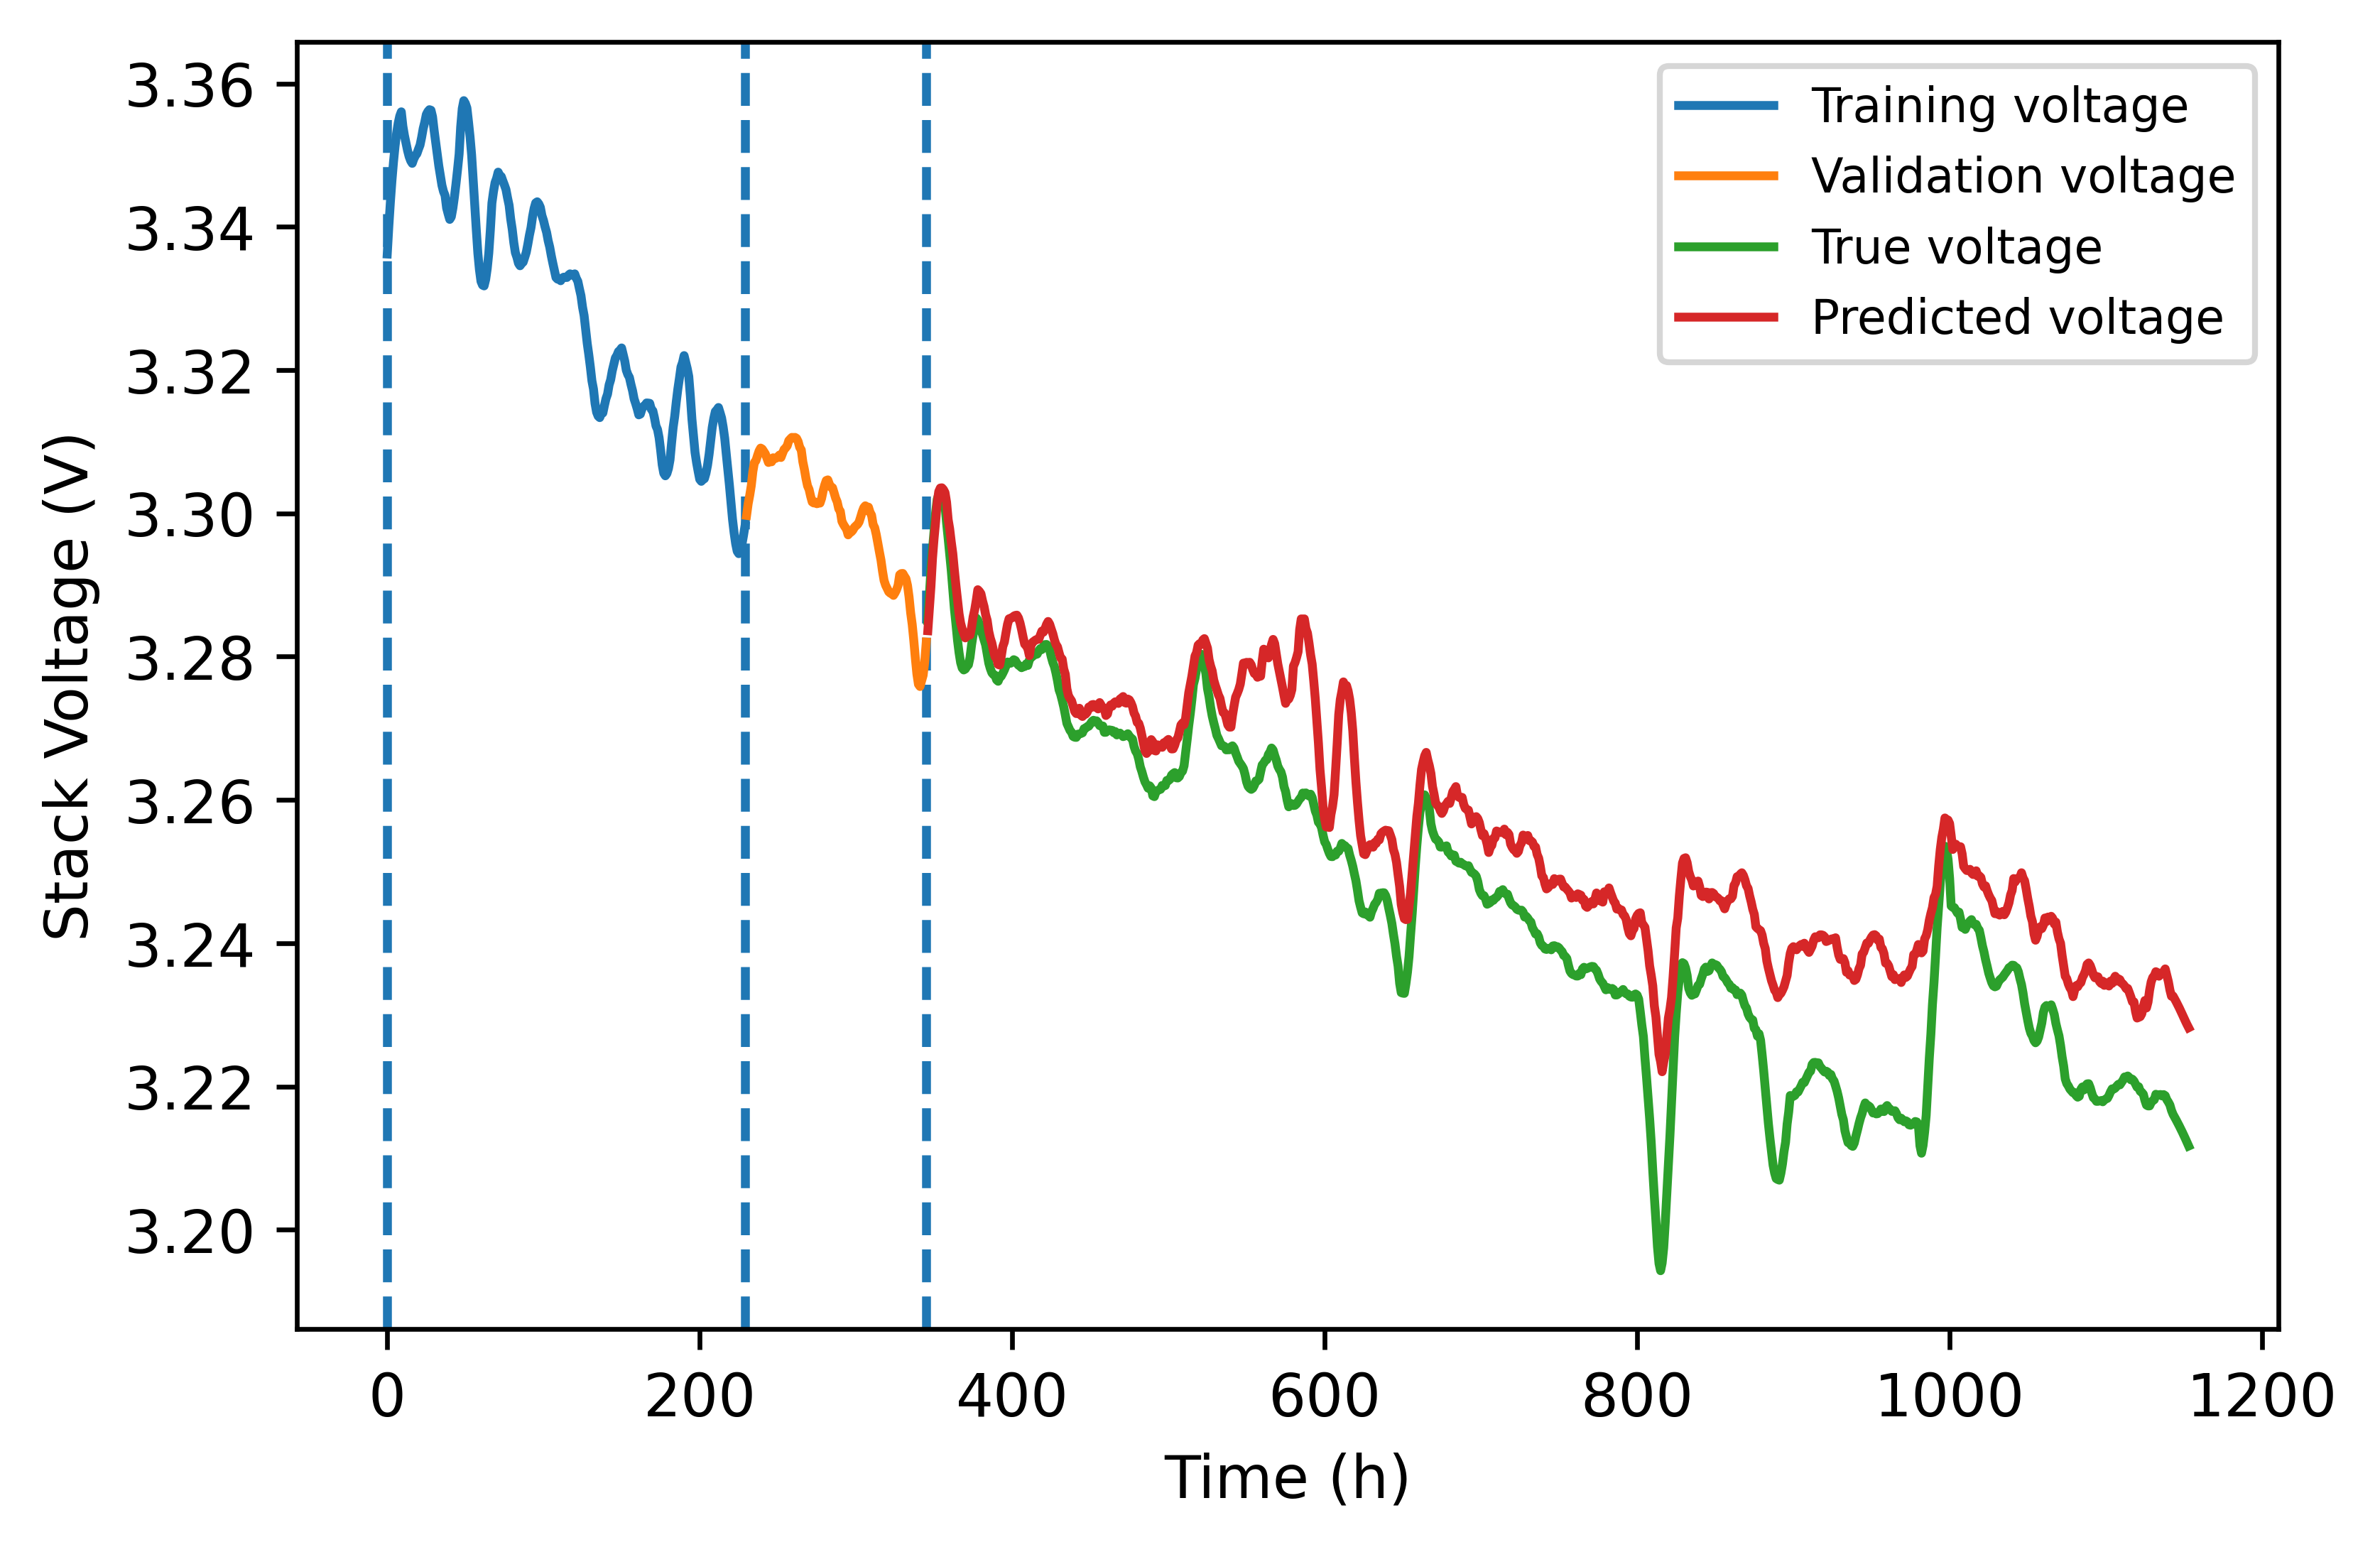

In [13]:
# Transfer Learning (phm_dataset_1-trained models tested on phm_dataset_2)
#transfer_learner = Neural_Networks(x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1)
#arr_RMSE, arr_MAE, arr_R2, arr_RUL, arr_RUL_RE, y_pred, y_true = transfer_learner.loop_model(1, df_type = 1)
#print(y_true.shape)
#print(pred_failure, true_failure)
fc1.plot_prediction_results(y_train_1, y_valid_1, y_test_1, y_true, y_pred, 235, 236)

In [ ]:
print(y_valid_s2.shape)

# LSTM Architecture

In [ ]:
# LSTM Network
sgd = keras.optimizers.SGD(momentum = 0.95)
mae = keras.losses.MeanAbsoluteError()
Adam = tf.keras.optimizers.Adam(learning_rate = 0.0032478577791734096)
# Prediction timeframe length: 604 h
# units of a Dense layer is the shape of the Dense layer output
# input_shape is the shape of the Dense layer input
lookback = 10 #hyperparameter
hidden_neurons = 59 # paper used 50
output_neurons = 1
epoch_size = 50
batch_size = 72
LSTM_layer = keras.layers.LSTM(hidden_neurons, input_shape = (normalized_train_features.shape[1], normalized_train_features.shape[2]), 
                               dropout = 0.018)
# Dropout added as validation loss increasing => DNN Overfitting
output_layer = keras.layers.Dense(1)
test_model = keras.Sequential(layers = (LSTM_layer, output_layer))
test_model.reset_states()
test_model.compile(optimizer = Adam, loss = mae)

In [ ]:
test_model.summary()
history = test_model.fit(normalized_train_features, normalized_train_volt, epochs = epoch_size, batch_size = batch_size, 
                         validation_data = (normalized_valid_features, normalized_valid_volt), shuffle = False)

In [ ]:
keras.backend.clear_session()
del test_model

In [ ]:
print(history.history.keys())
# Visualize Model Results
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, epoch_size + 1)
plt.plot(epochs, training_loss, label = 'Training Loss')
plt.plot(epochs, validation_loss, label = 'Validation Loss')
plt.legend()

In [ ]:
# Predict
yhat = test_model.predict(normalized_test_features)
sup_test_pred = normalized_test_features.reshape((normalized_test_features.shape[0], normalized_test_features.shape[2]))
#The above line took me 2 weeks to debug (https://stackoverflow.com/questions/73909740/unexpected-valueerror-after-training-keras-nn-a-few-times)
inv_yhat = np.concatenate((yhat, sup_test_pred[:, 1:]), axis = 1)
inv_yhat = volt_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = normalized_test_volt.reshape((len(normalized_test_volt), 1))
inv_y = np.concatenate((test_y, sup_test_pred[:, 1:]), axis = 1)
inv_y = volt_scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

In [ ]:
# Evaluate metrics
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print(f'Test RMSE: {rmse}, MAE: {mae}')
#print(len(inv_yhat), len(time_h[551:-1]))

In [ ]:
# Plot Predictions (WITHOUT RIPPLE)
plt.plot(time_h[:-1], sup_volt[:-1])
plt.plot(time_h[551:-1], inv_yhat)

In [ ]:
# Plot Predictions (WITH RIPPLE)
plt.plot(time_h[:-1], sup_volt[:-1])
plt.plot(time_h[510:-1], inv_yhat)

# CNN Architecture

In [ ]:
# LSTM-CNN Network
# Prediction timeframe length: 604 h
# units of a Dense layer is the shape of the Dense layer output
# input_Shape is the shape of the Dense layer input
keras.backend.clear_session()
sgd = keras.optimizers.SGD(momentum = 0.95)
mae = keras.losses.MeanAbsoluteError()
Adam = tf.keras.optimizers.Adam(learning_rate = 0.0011845727280723685)
lookback = 10 #hyperparameter
hidden_neurons = 50
output_neurons = 1
epoch_size = 50
batch_size = 72
LSTM1 = keras.layers.LSTM(hidden_neurons, input_shape = (normalized_train_features.shape[1], normalized_train_features.shape[2]), dropout = 0.1518397185443487)
bidir_LSTM1 = keras.layers.Bidirectional(LSTM1)
conv1D = keras.layers.Conv1D(filters = 56, kernel_size = 3, strides = 1, activation = "tanh", padding = 'causal')#, input_shape = (None, 23))
cnn_model = keras.Sequential(layers = (conv1D, LSTM1, keras.layers.Dense(1)))
cnn_model.reset_states()
cnn_model.compile(optimizer = Adam, loss = 'mae')

In [ ]:
cnn_model.build(input_shape = (None, 1,23))
cnn_model.summary()
history = cnn_model.fit(sup_train, train_y, epochs = epoch_size, batch_size = batch_size, validation_data=(sup_test, test_y), shuffle=False)

In [ ]:
# Visualize Model Results
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, epoch_size + 1)
plt.plot(epochs, training_loss, label = 'Training Loss')
plt.plot(epochs, validation_loss, label = 'Validation Loss')
plt.legend()
print(sup_test.shape)

In [ ]:
# Predict
yhat = cnn_model.predict(sup_test)
sup_test_pred = sup_test.reshape((sup_test.shape[0], sup_test.shape[2]))
inv_yhat = np.concatenate((yhat, sup_test_pred[:, 1:]), axis=1)
inv_yhat = volt_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, sup_test_pred[:, 1:]), axis=1)
inv_y = volt_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Evaluate metrics
rmse, mae, r2 = evaluate_metrics(inv_y, inv_yhat) # Function defined on top
print(f'Test RMSE: {rmse}, MAE: {mae}, R2: {r2}')

In [ ]:
del cnn_model
keras.backend.clear_session()

#Hyperparameter Optimization

In [ ]:
#cuDNN GPU accelerator not applied to LSTM/GRU layers not meeting specified criteria (https://stackoverflow.com/a/68846093)
class optuna_search():
    """
    Use the Optuna Python package for hyperparameter optimization
    """

    def __init__(self, x_train, y_train, x_valid, y_valid, x_test, y_test, scaler) -> None:
        # self.model = model
        self.neural_network = Neural_Networks(x_train, y_train, x_valid, y_valid, x_test, y_test, scaler)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler


    def build_deep_model(self, trial):
        """
        Function to build custom models with arbitrary number of hidden layers. 
        Definition changed each time a new model with arbitrary number of hidden layers is optimized.
        Used for pure LSTM and GRU models only
        """
        output_neurons = 1
        layers = list()
        optimizer =  self.create_optimizer(trial)
        n_layers = trial.suggest_int("n_hidden_layers", 1, 10)
        drop_out = trial.suggest_float('dropout', 0.01, 0.5)
        if n_layers > 1:
          layers = [keras.layers.LSTM(trial.suggest_int("n_units_L{}".format(_), 30, 100), 
                                            input_shape = (self.x_train.shape[1], self.x_train.shape[2]), return_sequences = True) for _ in range(n_layers)]
        layers.append(keras.layers.LSTM(trial.suggest_int("n_units_L{}".format(n_layers), 30, 100), 
                                        input_shape = (self.x_train.shape[1], self.x_train.shape[2]), dropout = drop_out))
        layers.append(keras.layers.Dense(output_neurons))
        deep_model = keras.Sequential(layers = layers)
        deep_model.reset_states()
        deep_model.compile(optimizer = optimizer, loss = 'mae')
        return deep_model


    def create_optimizer(self, trial):
        """
        Create optimizer selection
        """
        kwargs = {}
        optimizer_options = ['Adam', 'SGD', 'RMSprop']
        optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
        if optimizer_selected == "RMSprop":
            kwargs["learning_rate"] = trial.suggest_float(
                "rmsprop_learning_rate", 1e-5, 1e-1, log=True)
            kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
            kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
        elif optimizer_selected == "Adam":
            kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
        elif optimizer_selected == "SGD":
            kwargs["learning_rate"] = trial.suggest_float(
                "sgd_opt_learning_rate", 1e-5, 1e-1, log=True)
            kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-3, 99e-2, log=True)

        optimizer = getattr(tf.keras.optimizers.legacy, optimizer_selected)(**kwargs)
        return optimizer


    def objective_function(self, trial):
        """
        Objective function to optimize
        """
        #dropout = trial.suggest_float('dropout', 0.01, 0.5)
        #units = trial.suggest_int('units', 30, 110) #hidden_neurons
        #units_1 = trial.suggest_int('units_1', 30, 100) #hidden_neurons
        #activation = trial.suggest_categorical("activation", ['relu', 'tanh', 'softsign'])
        #activation_1 = trial.suggest_categorical("activation", ['relu', 'tanh', 'softsign'])
        #optimizer =  self.create_optimizer(trial)
        #filters = trial.suggest_int('filters', 30, 100) #filters for CNN
        test_model = self.build_deep_model(trial)
        self.neural_network.train_model(test_model)
        y_true, y_pred = self.neural_network.predict(test_model)
        return self.neural_network.evaluate_loss_function(y_true, y_pred)


    def optimize_study(self):
        """
        """
        from optuna.visualization import plot_optimization_history, plot_param_importances
        from optuna.importance import get_param_importances
        study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(),
                                    pruner = optuna.pruners.HyperbandPruner())
        study.optimize(self.objective_function, n_trials = 100)
        plot_optimization_history(study).show()
        print(get_param_importances(study))
        return study.best_params, study.best_value
  

    def optimize(self):
        best_params, best_values = self.optimize_study()
        print(f"Best params: {best_params}\n Best value: {best_values}")
        return self

In [ ]:
param_optimizer = optuna_search(x_train_s1, y_train_s1, x_valid_s1, y_valid_s1, x_test_s1, y_test_s1, volt_scaler_1)
param_optimizer.optimize()

#RMSE/MAE/R2 Array Plots

In [2]:
#Transfer Learning arrays
#LSTM
lstm_fc1_rmse = [0.00501319, 0.00323976, 0.00207025, 0.00432291, 0.00175713, 0.00240187,
            0.00253401, 0.00203549, 0.0073066 , 0.00256366, 0.00292492, 0.00305408,
            0.00219274, 0.00415199, 0.00157253, 0.00408891, 0.00331121, 0.00203972,
            0.00219243, 0.0033363 , 0.00244547, 0.00296717, 0.00210577, 0.00221431,
            0.00218254, 0.00383498, 0.00277628, 0.00374345, 0.0018332 , 0.00226994,
            0.00420192, 0.0026477 , 0.0015356 , 0.0032732 , 0.00151482, 0.00358147,
            0.0031156 , 0.00198296, 0.00343036, 0.00212511, 0.00238046, 0.00299178,
            0.00130471, 0.00211046, 0.00520197, 0.00205453, 0.00127829, 0.00205043,
            0.00125842, 0.00422602]
lstm_fc1_mae = [0.00462907, 0.00260474, 0.00165518, 0.00371815, 0.00137869, 0.0020249,
            0.0021283 , 0.00155425, 0.00611091, 0.00217355, 0.00259425, 0.00238101,
            0.00160082, 0.00333551, 0.0011978 , 0.00331473, 0.00300282, 0.00160929,
            0.00170509, 0.00235878, 0.00189122, 0.00249353, 0.00170157, 0.00191988,
            0.00180431, 0.00290035, 0.00234428, 0.00302254, 0.00144153, 0.00180418,
            0.00280605, 0.00221824, 0.00113009, 0.00286539, 0.00109463, 0.00268741,
            0.0027902 , 0.00152226, 0.00293466, 0.00173929, 0.00194735, 0.00230844,
            0.00093468, 0.00162538, 0.00429763, 0.00163891, 0.00085877, 0.00157464,
            0.00088358, 0.00349788]
lstm_fc1_r2 = [0.8210524,  0.92526522, 0.96948287,  0.86693924,  0.97801605,  0.95892325,
             0.9542791 , 0.9704991, 0.61987316, 0.95320311, 0.9390848  , 0.93358605,
             0.96576477, 0.87725293, 0.98239267, 0.88095475, 0.92193256 , 0.97037635,
             0.96577462, 0.92074473, 0.95741833, 0.93731229, 0.96842667 , 0.96508811,
             0.9660827 , 0.89528127, 0.94511885, 0.90022047, 0.97607148 , 0.96331193,
             0.87428328, 0.9500847, 0.98320992, 0.92371454, 0.98366112 , 0.90866856,
             0.93088377, 0.97200201, 0.91621299, 0.9678442, 0.95965221 , 0.93626804,
             0.98787942, 0.96828608, 0.80732147, 0.96994457, 0.98836525 , 0.97006431,
             0.98872424, 0.87283687]

# FC2 Arrays
bidirgru_cnn_fc2_rmse = [0.00417093, 0.00297497, 0.00221024, 0.00215195, 0.00220566, 0.00373636, 0.00242787, 0.0032458, 
            0.00279137, 0.00253677, 0.00257304, 0.00481353, 0.00523333, 0.00256564, 0.00199833, 0.00196094, 0.00880736, 0.00569156,
            0.00325265, 0.00363585, 0.0027193 , 0.00211697, 0.00418082, 0.00557841,
            0.0024764 , 0.00217814, 0.00259733, 0.00237554, 0.002299  , 0.00223441,
            0.00487565, 0.00531514, 0.00232652, 0.00353869, 0.00467179, 0.00317592,
            0.00287281, 0.00247696, 0.00523771, 0.00198619, 0.00312848, 0.00283472,
            0.00186797, 0.00251786, 0.00340422, 0.00177566, 0.00834544, 0.00704167, 0.00269034, 0.00206095]
bidirgru_cnn_fc2_mae = [0.0036693, 0.00239677, 0.00182525, 0.00179678, 0.00174969, 0.00320095,
            0.00198113, 0.00268249, 0.00232475, 0.00202966, 0.00217818, 0.00402775,
            0.00489727, 0.0021769 , 0.00165806, 0.00163017, 0.00847703, 0.00509838,
            0.00273861, 0.00309402, 0.00228747, 0.00172433, 0.0038949 , 0.00515875,
            0.00212374, 0.00174741, 0.00208322, 0.00185757, 0.00191045, 0.00177703,
            0.0042981 , 0.00502366, 0.00185846, 0.00308741, 0.00401648, 0.00260096,
            0.0023501 , 0.00197714, 0.0047455 , 0.00164174, 0.00249328, 0.00222188,
            0.00155886, 0.00213352, 0.00288821, 0.00143449, 0.00791106, 0.00652456, 0.00212223, 0.0015888]
bidirgru_cnn_fc2_r2 = [0.97144308, 0.98547183, 0.99198089, 0.99239832, 0.99201408, 0.97708375,
            0.99032395, 0.98270625, 0.98720974, 0.98943652, 0.98913224, 0.96196582,
            0.95504251, 0.98919471, 0.99344487, 0.9936879 , 0.87266817, 0.94682485,
            0.98263313, 0.97830012, 0.9878616 , 0.99264341, 0.97130751, 0.94891813,
            0.98993326, 0.99221213, 0.98892611, 0.99073662, 0.9913239 , 0.9918046,
            0.96097787, 0.95362599, 0.99111493, 0.97944433, 0.96417289, 0.98344285,
            0.9864525 , 0.98992874, 0.95496729, 0.9935243 , 0.98393384, 0.98680931,
            0.99427222, 0.98959339, 0.98097685, 0.99482437, 0.88567423, 0.918605, 0.98811883, 0.99302762]


lstm_tf_rmse = [0.00183976, 0.00193768, 0.00221101, 0.00282407, 0.00223015, 0.00169132, 0.00362214, 0.00240511, 0.00198698, 0.00348913, 0.00294883, 0.00194565,
 0.00180705, 0.00240557, 0.00285774, 0.00236182, 0.00309964, 0.00170527,
 0.00261875, 0.00161297, 0.00212776, 0.00293118, 0.00167698, 0.00228626,
 0.00391972, 0.00158447, 0.00308138, 0.0041632 , 0.00270827, 0.003764,
 0.00155557, 0.00172021, 0.00204219, 0.00217309, 0.00186359, 0.00429378,
 0.00184051, 0.00180145, 0.0016614 , 0.00349141, 0.00248899, 0.002458,
 0.00431704, 0.00187797, 0.00182439, 0.00184119, 0.00161871, 0.00388922,
 0.00246144, 0.00167138]

lstm_tf_mae = [0.00138983, 0.00154133, 0.0017953 , 0.00244724, 0.00179232, 0.00132451,
 0.0032478 , 0.00191346, 0.00156843, 0.00303729, 0.00242473, 0.00149194,
 0.00140801, 0.00190037, 0.0024792 , 0.00197693, 0.00276579, 0.00125401,
 0.00224339, 0.00124728, 0.00163939, 0.00238257, 0.00124957, 0.00189337,
 0.00356667, 0.00118827, 0.00267126, 0.00389104, 0.00237676, 0.00337651,
 0.00126666, 0.00135345, 0.00159299, 0.00166461, 0.00141898, 0.00393059,
 0.00139008, 0.00138887, 0.00132286, 0.00308715, 0.00211618, 0.00200908,
 0.00398472, 0.0014683 , 0.00133131, 0.00143482, 0.00122811, 0.00345019,
 0.00195032, 0.00124239]

lstm_tf_r2 = [0.99444393, 0.99383676, 0.99197534, 0.98690829, 0.99183582, 0.99530434,
 0.97846338, 0.99050452, 0.99351916, 0.98001608, 0.98572601, 0.99378597,
 0.99463973, 0.99050095, 0.98659428, 0.99084326, 0.98422869, 0.99522658,
 0.98874274, 0.99572933, 0.99256824, 0.98589641, 0.99538359, 0.99141982,
 0.97477943, 0.99587888, 0.98441391, 0.97154887, 0.98795988, 0.97674343,
 0.99602784, 0.99514252, 0.99315398, 0.99224822, 0.99429904, 0.96973608,
 0.99443941, 0.9946729 , 0.99546899, 0.97999002, 0.98983065, 0.99008234,
 0.96940727, 0.99421072, 0.99453638, 0.99443526, 0.99569884, 0.97517028,
 0.99005454, 0.99541438]


bidirgru_cnn_tf_rmse = [0.00308221, 0.00324458, 0.00741442, 0.00231866, 0.00283982, 0.00217173,
 0.00652954, 0.00444925, 0.00386382, 0.00509401, 0.00638017, 0.00662081,
 0.00257051, 0.00210943, 0.00463341, 0.00168647, 0.00280211, 0.00217746,
 0.00969141, 0.00436354, 0.00790382, 0.00525548, 0.00200773, 0.0020301,
 0.00190198, 0.00339351, 0.00341113, 0.01368516, 0.00352972, 0.00446984,
 0.016144  , 0.00483843, 0.00362644, 0.00666088, 0.0052734 , 0.0043735,
 0.00432284, 0.01485844, 0.00367632, 0.00273968, 0.00192603, 0.00306099,
 0.00195664, 0.00555524, 0.00245874, 0.00471562, 0.00496635, 0.00363776,
 0.00217609, 0.01460139]

bidirgru_cnn_tf_mae = [0.00254841, 0.00281594, 0.00655678, 0.00184442, 0.00241935, 0.00162881,
 0.00571267, 0.00337232, 0.0033544 , 0.00464804, 0.00511756, 0.00567012,
 0.00202715, 0.00159481, 0.00429474, 0.00124615, 0.0022334 , 0.00174397,
 0.00905871, 0.00390713, 0.00687417, 0.00451768, 0.00157075, 0.0016005,
 0.00154222, 0.00254391, 0.00282943, 0.01316217, 0.00301089, 0.00361214,
 0.01559699, 0.00429413, 0.00283705, 0.00582292, 0.00386394, 0.00368505,
 0.00352238, 0.01431994, 0.00292921, 0.0022199 , 0.00152242, 0.00256477,
 0.0015042 , 0.00516467, 0.00195162, 0.00414299, 0.00450058, 0.00320361,
 0.00169488, 0.01418815]

bidirgru_cnn_tf_r2 = [0.98440557, 0.9827192 , 0.90975972, 0.99117488, 0.98676184, 0.9922579,
 0.93001405, 0.96750485, 0.97549361, 0.95740434, 0.93317936, 0.92804381,
 0.98915367, 0.99269573, 0.96475915, 0.99533121, 0.98711113, 0.99221705,
 0.84582287, 0.96874465, 0.89745382, 0.95466107, 0.99338309, 0.9932348,
 0.99406178, 0.98109641, 0.98089961, 0.69257062, 0.97954844, 0.96720325,
 0.57217312, 0.96157144, 0.97841233, 0.92717025, 0.95435144, 0.96860178,
 0.96932498, 0.63759675, 0.97781432, 0.98767898, 0.99391062, 0.98461955,
 0.99371554, 0.94934167, 0.99007635, 0.96349736, 0.95951246, 0.97827732,
 0.99222682, 0.6500274]

In [ ]:
models_arr = [_ for _ in range(1, 51)]
plt.plot(models_arr, lstm_fc1_rmse, label = 'Direct Training', marker='o', fillstyle = 'none')
plt.plot(models_arr, lstm_tf_rmse, label = 'Transfer Learning', marker='o', fillstyle = 'none')
plt.ylabel('RMSE (V)'); plt.xlabel('Trial no.')
plt.legend();# plt.title('LSTM RMSE')

In [ ]:
models_arr = [_ for _ in range(1, 51)]
plt.plot(models_arr, lstm_fc1_mae, label = 'Direct Training', marker='o', fillstyle = 'none')
plt.plot(models_arr, lstm_tf_mae, label = 'Transfer Learning', marker='o', fillstyle = 'none')
plt.ylabel('MAE'); plt.xlabel('Trial no.')
plt.legend();# plt.title('LSTM MAE')

In [ ]:
models_arr = [_ for _ in range(1, 51)]
plt.plot(models_arr, lstm_fc1_r2, label = 'Direct Training', marker='o', fillstyle = 'none')
plt.plot(models_arr, lstm_tf_r2, label = 'Transfer Learning', marker='o', fillstyle = 'none')
plt.ylabel('R$^2$'); plt.xlabel('Trial no.')
plt.legend();# plt.title('LSTM R2')

In [ ]:
models_arr = [_ for _ in range(1, 51)]
plt.plot(models_arr, bidirgru_cnn_fc2_rmse, label = 'Direct Training', marker='o', fillstyle = 'none')
plt.plot(models_arr, bidirgru_cnn_tf_rmse, label = 'Transfer Learning', marker='o', fillstyle = 'none')
plt.ylabel('RMSE (V)'); plt.xlabel('Trial no.')
plt.legend();# plt.title('BidirGRU-CNN RMSE')

In [ ]:
models_arr = [_ for _ in range(1, 51)]
plt.plot(models_arr, bidirgru_cnn_fc2_mae, label = 'Direct Training', marker='o', fillstyle = 'none')
plt.plot(models_arr, bidirgru_cnn_tf_mae, label = 'Transfer Learning', marker='o', fillstyle = 'none')
plt.ylabel('MAE'); plt.xlabel('Trial no.')
plt.legend();# plt.title('BidirGRU-CNN MAE')

In [ ]:
models_arr = [_ for _ in range(1, 51)]
plt.plot(models_arr, bidirgru_cnn_fc2_r2, label = 'Direct Training', marker='o', fillstyle = 'none')
plt.plot(models_arr, bidirgru_cnn_tf_r2, label = 'Transfer Learning', marker='o', fillstyle = 'none')
plt.ylabel('R$^2$'); plt.xlabel('Trial no.')
plt.legend()#; plt.title('BidirGRU-CNN R2')